# Réseaux de neurones et classification d'images avec MLP

Le but de ce TP est de e familiariser avec la classification d'images sur un corpus d'images simples, avant d'approfondir la semaine prochaines sur des images plus réalistes.

Le but du TP est de remplir les zones de code vides pour implémenter un programme qui peut classer correctement les images (avec un taux d'erreur inférieur à 10% )

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader


from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Resize
import matplotlib.pyplot as plt


## Utilisation GPU
le code suivant vérifie que le GPU est disponible, et l'utilise si c'est le cas.
Si la valeur de `use_cuda` est `False`, vous devez changer le type de machine pour avoir accès à un GPU.

In [ ]:
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")

True


## Préparation des données

Torchvision contient des jeux de données pour entraîner et évaluer les réseaux.
Nous utilisons [MNIST](https://en.wikipedia.org/wiki/MNIST_database).

On récupère les données d'entraînement et de test, puis on réserve une partie des données d'entraînement, qu'on appelle données de validation, pour sélectionner le meilleur modèle.
Ensuite, on nomme les différentes classes d'images.

In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

training_data, val_data = torch.utils.data.random_split(training_data, [50000, 10000])

NB_CLASSES=10

labels_map = {
    0: "Zero",
    1: "One",
    2: "Two",
    3: "Three",
    4: "Four",
    5: "Five",
    6: "Six",
    7: "Seven",
    8: "Eight",
    9: "Nine",
}


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.30MB/s]


Ce corpus est constitué d'images en noir et blanc de taille 28×28. Ces images représentent des chiffres réparties en 10 classes différentes.

Chacune des cases (28$\times$ 28=784) contient une valeur entre 0 et 1, qui indique un niveau de gris, avec 0 pour les points noirs et 1 pour les points blancs.

Notez bien que même si ces images peuvent être représentées par une matrice 28×28, elles sont en faites stockées comme des tenseurs 1×28×28 de façon à expliciter qu'au lieu des habituels 3 canaux RGB indiquant les couleurs, qu'on verra en détails la semaine prochaine, on n'a ici qu'un seul canal qui indique le niveau de gris.

La fonction suivante affiche une sélection aléatoire de chiffres:



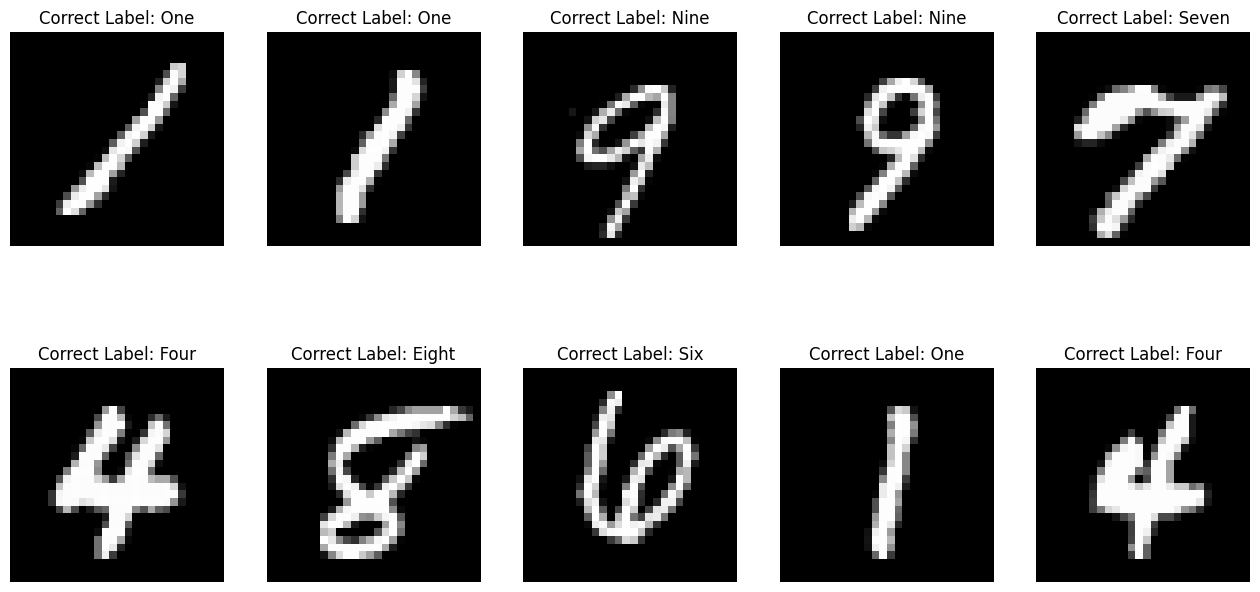

In [ ]:
def display_examples(cols=5, rows=2, net=None, data=training_data):
  figure = plt.figure(figsize=(16, 8))
  for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_idx]
    figure.add_subplot(rows, cols, i)

    if net is None:
      label = "Correct Label: " + labels_map[label]
    else:
      imgdev = img.to(device)
      scores = net(imgdev)
      pred = torch.argmax(scores)
      label = "Predicted Label: " + labels_map[pred.item()]

    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
  plt.show()

display_examples()

## On charge les données

pour pouvoir être chargées facilement on crée des `DataLoader` qui vont nous permettre d'itérer facilement sur les données



In [ ]:
BATCH_SIZE=512 #nombre d'images à traiter en parallèle

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

On dispose maintenant d'itérateurs sur les données `next`. On peut écrire par exemple :



Feature batch shape: torch.Size([512, 1, 28, 28])
Labels batch shape: torch.Size([512])


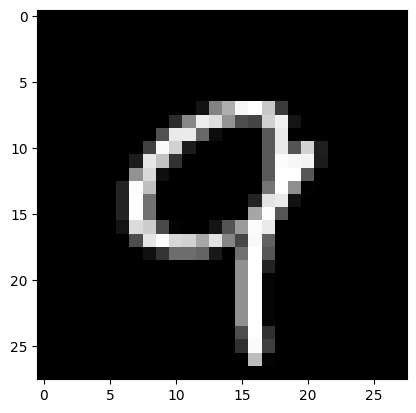

Label: 9


In [ ]:
# Display image and label.
train_iter = iter(train_dataloader) #get an iterator over data
train_features, train_labels = next(train_iter) # get a batch of data
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze() # reformat the first pic as 28x28
label = train_labels[0]
plt.imshow(img, cmap="gray") #it's B&W
plt.show()
print(f"Label: {label}")

Que contient notre image ?

In [ ]:
print(img)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

## Évaluation
La fonction suivante compare, pour un jeu de données passé en paramètre, la classe `argmax` calculée par un réseau et le label qui devait être prédit.
Si ces valeurs sont égales alors elles comptent pour de bonnes réponses.
On retourne le ratio de bonnes réponses.

In [ ]:
def eval(net, dataloader, device):

  total_test = 0.0
  correct_test = 0.0

  net.eval()

  #iterate over data
  for local_batch, local_labels in dataloader:
    # Transfer to GPU
    local_batch, local_labels = local_batch.to(device), local_labels.to(device)

    preds = net(local_batch)
    total_test += preds.size(0)
    correct_test += (torch.argmax(preds, dim=1) == local_labels).sum()

  return correct_test/total_test

# Implémentation d'un Perceptron multicouche

Implementer la class MLP pour les perceptrons multicouches.

Le constructeur prend en entrée:

    input_size la taille du vecteur d'entrée
    hidden_sizes la liste des tailles des couches internes
    output_size la taille de la couche de sortie
    activation la classe qui implémente la fonction à appliquer après chaque transformation linéaire

Aide: vous pouvez utiliser la classe Sequential pour modéliser la liste des transformations de votre MLP

La fonction forward prend entrée une image. Il faut d'abord transformer l'image (le tenseur à 3 dimensions) en un vecteur, puis on applique successivement chaque transformation linéaire, suivie d'une activation si on n'est pas sur la dernière couche.

In [ ]:
class MLP(torch.nn.Module):

  def __init__(self, input_size, hidden_sizes, output_size, activation):
    super().__init__()

    #your code begins here
    layers = []
    in_dim = input_size

    # couches cachées
    for h in hidden_sizes:
      layers.append(torch.nn.Linear(in_dim, h))
      layers.append(activation())
      in_dim = h

    # couche de sortie (sans activation)
    layers.append(torch.nn.Linear(in_dim, output_size))

    self.net = torch.nn.Sequential(*layers)
    #your code ends here

  def forward(self,x):
    #your code begins here
    # x : (batch_size, 1, 28, 28) -> on aplatit en vecteur
    x = x.view(x.size(0), -1)
    return self.net(x)
    #your code ends here


## Boucle d'entraînement

Écrire la fonction `train` qui implément la boucle d'apprentissage

In [ ]:
def train(net, optimizer, epochs, train_data, val_data, test_data, batch_size, device, eval_frq=10):

  loss_fn = torch.nn.CrossEntropyLoss()

  total_loss = 0.0

  n_batches = 0
  for epoch in range(epochs):

    net.train()
    # iterate through train data
    #   -> get new batch
    #   -> send it to device
    #   -> compute class scores with net
    #   -> compute loss and compute the gradient of the loss
    #   -> call step() on optimizer to perform SGD, reset gradients to zero

    #your code begins here
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    for local_batch, local_labels in train_loader:
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)

        preds = net(local_batch)
        loss = loss_fn(preds, local_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        n_batches += 1
    #your code ends here


    # eval if it's time...
    if epoch % eval_frq == 0:
      print(f"Epoch: {epoch}, Mean loss: {total_loss/n_batches}")
      rv=eval(net, val_dataloader, device)
      #  --> Display eval scores rt and rv
      display_examples(cols=5, rows=2, net=net, data=val_data)
      rt=eval(net, test_dataloader, device)
      display_examples(cols=5, rows=2, net=net, data=test_data)


## Création du réseau

Donner les bon paramètres pour la création de `net`.


Enuiste, modifier la fonction `display_examples` pour que si le paramètre `net` n'est pas `None` alors au lieu d'afficher le label correct des images, on affiche le label prédit par `net`, c'est-à-dire la classes `argmax`.

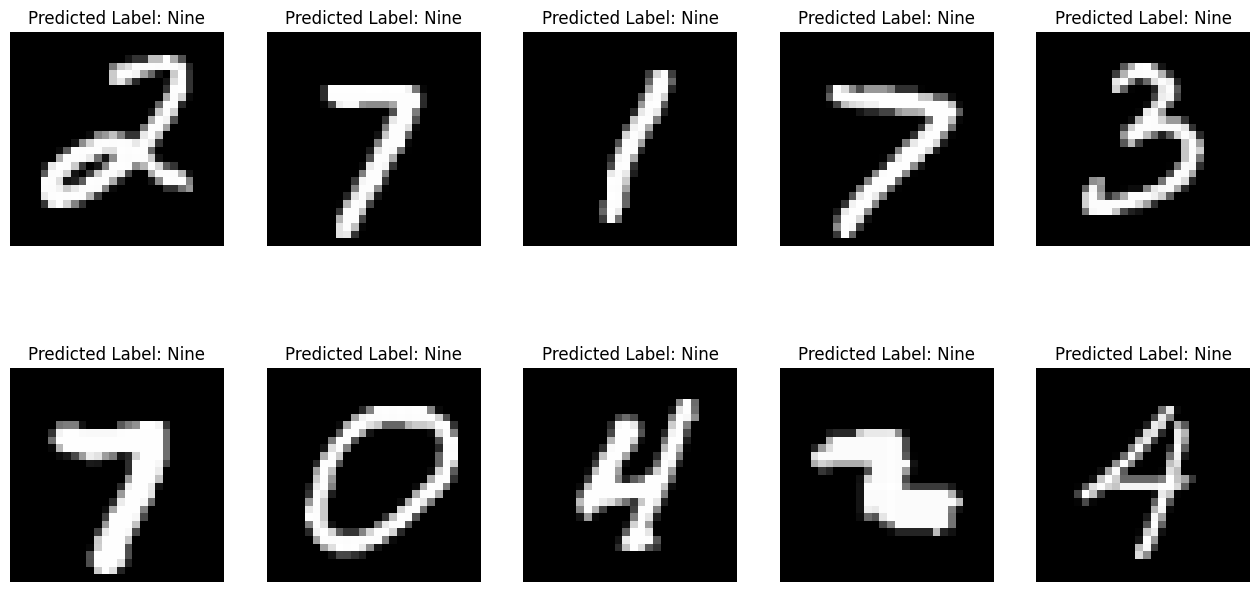

In [17]:
net = MLP(28*28, [256,128,64], NB_CLASSES, torch.nn.Sigmoid)
net = net.to(device)

display_examples(net=net)

## TEST

Epoch: 0, Mean loss: 0.0013067370740345167


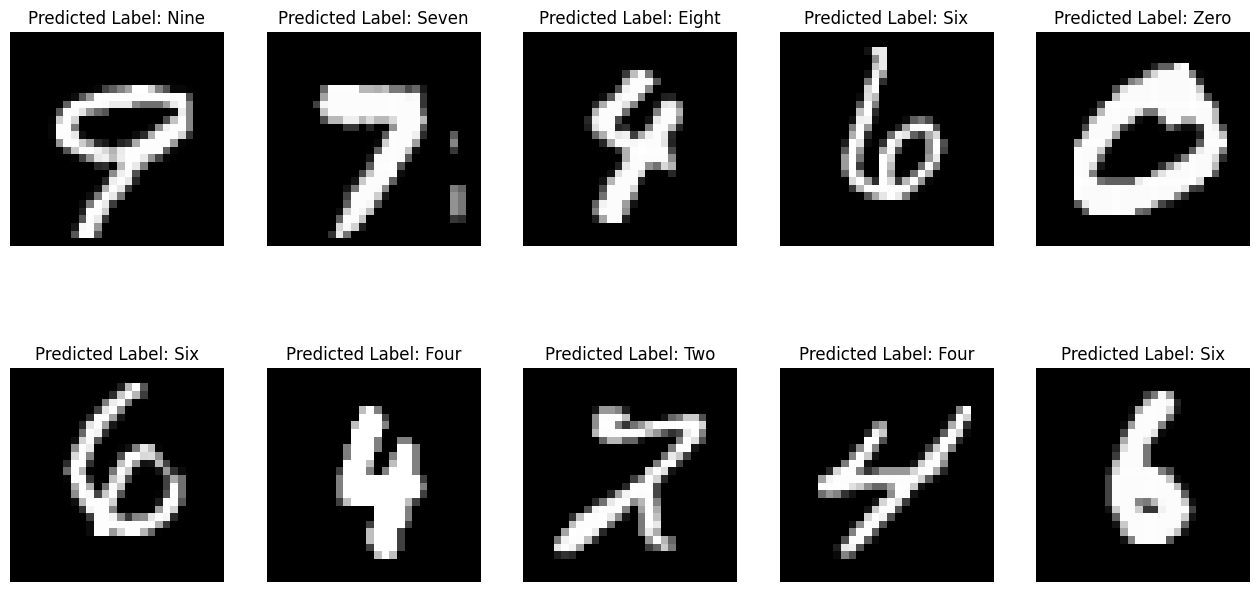

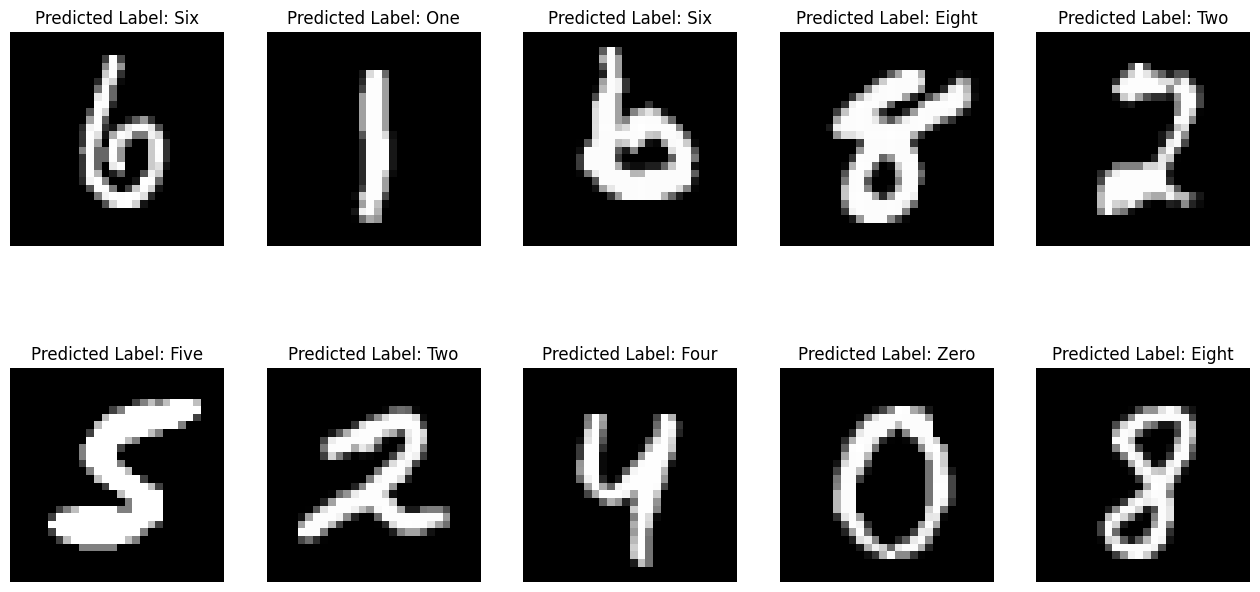

Epoch: 5, Mean loss: 0.0011354419664118666


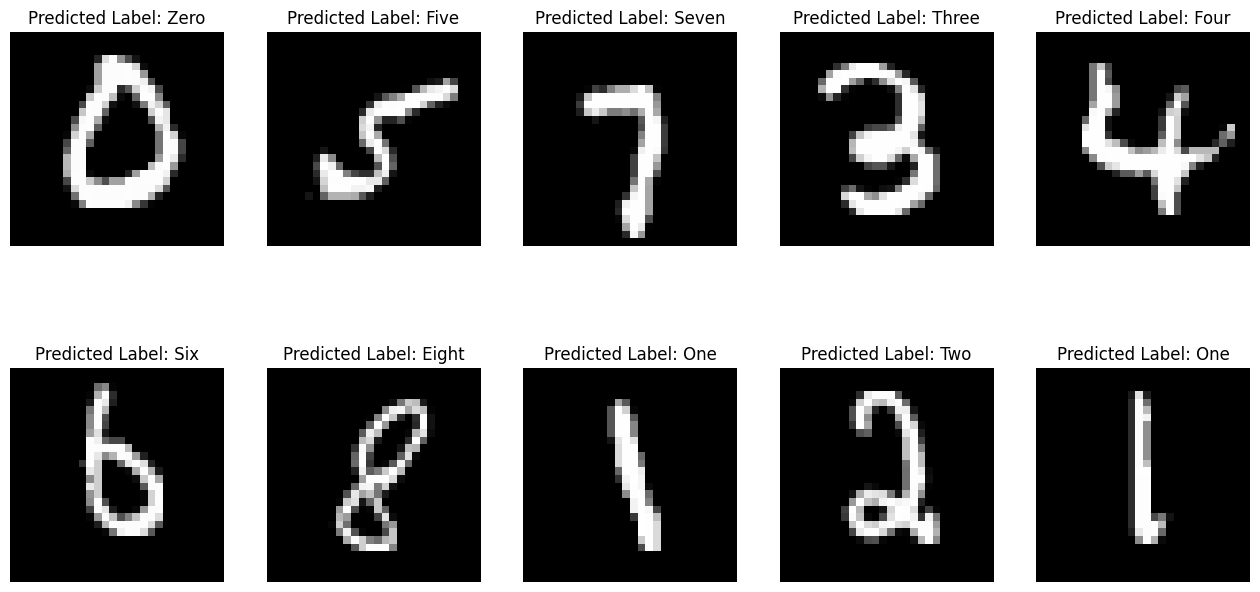

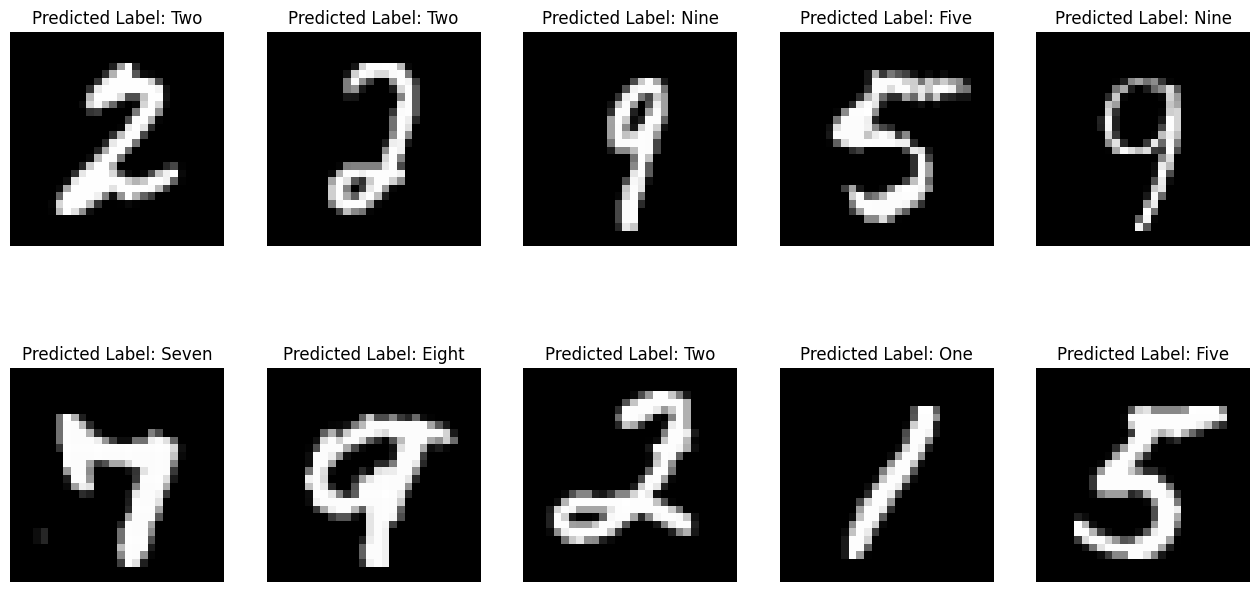

Epoch: 10, Mean loss: 0.0010035081255419874


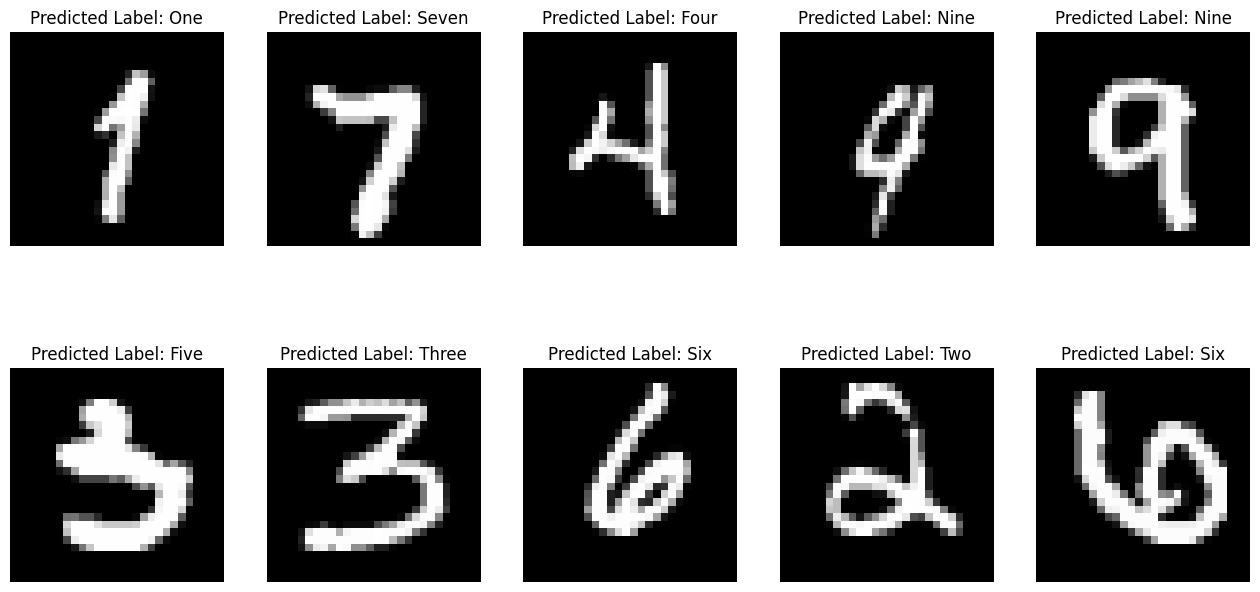

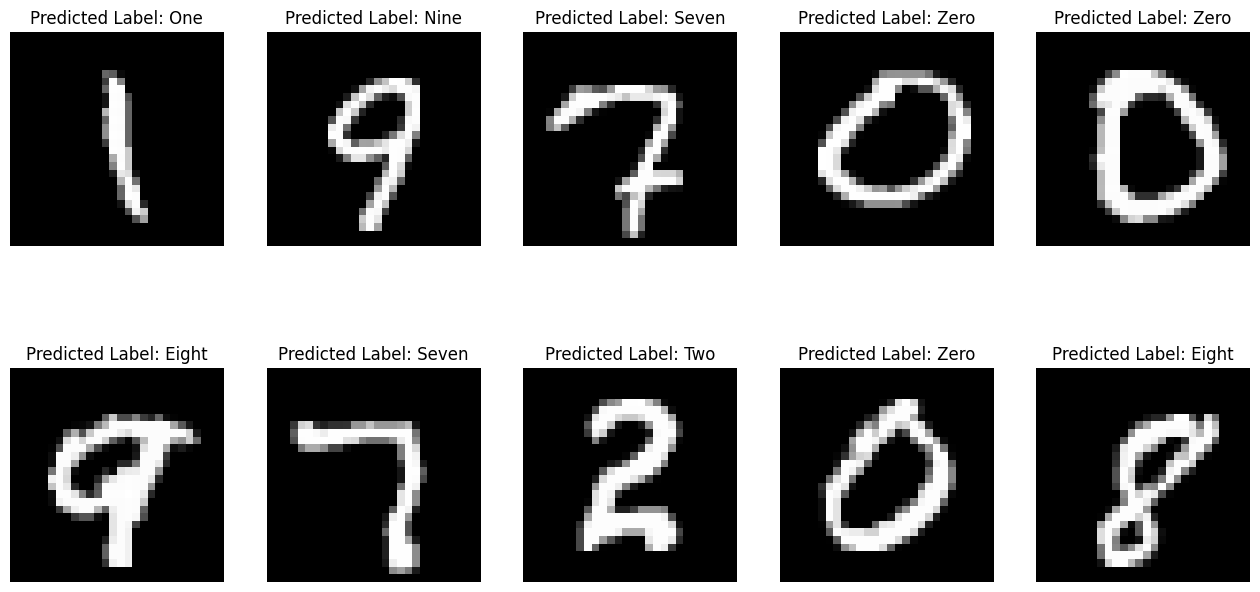

Epoch: 15, Mean loss: 0.00089670389243853


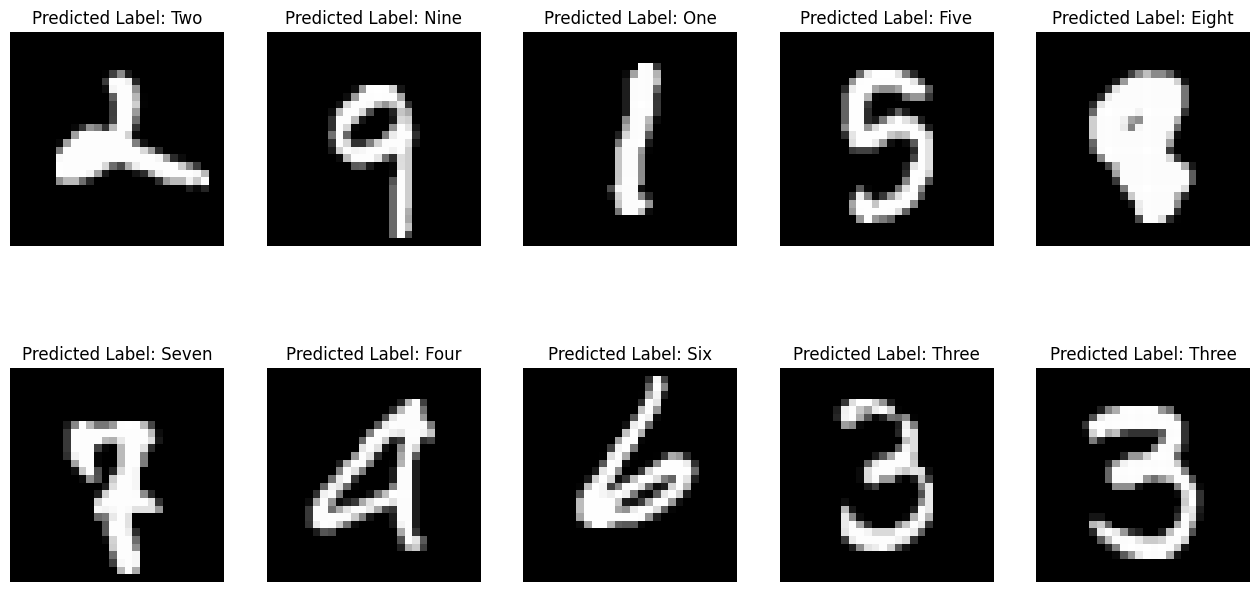

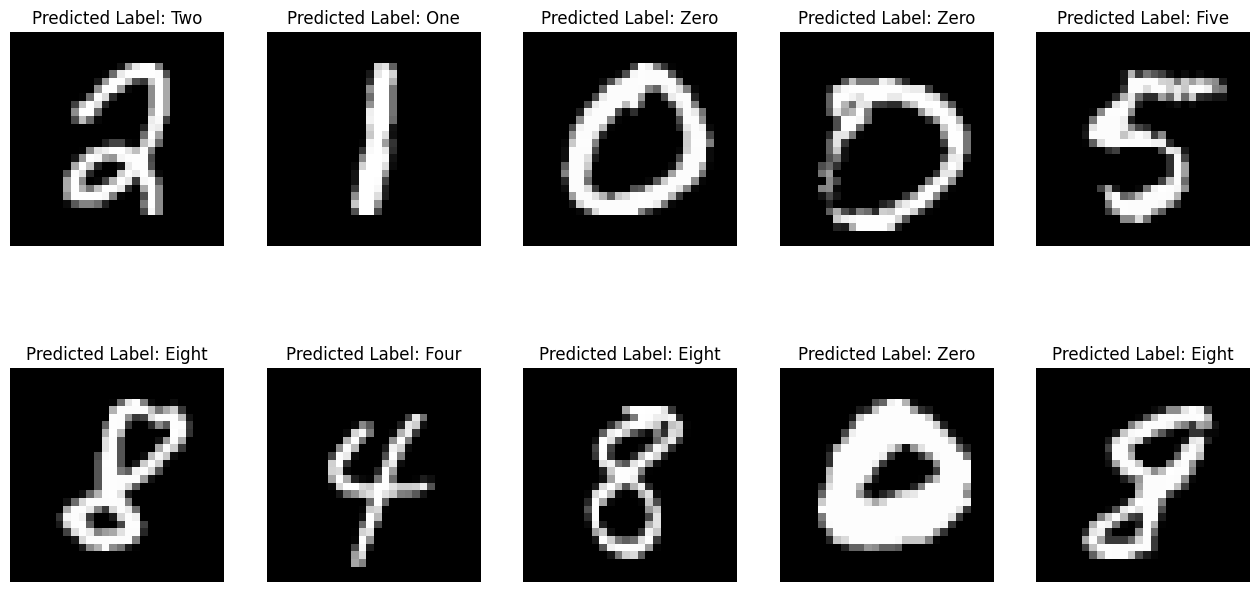

Epoch: 20, Mean loss: 0.0008056299990727847


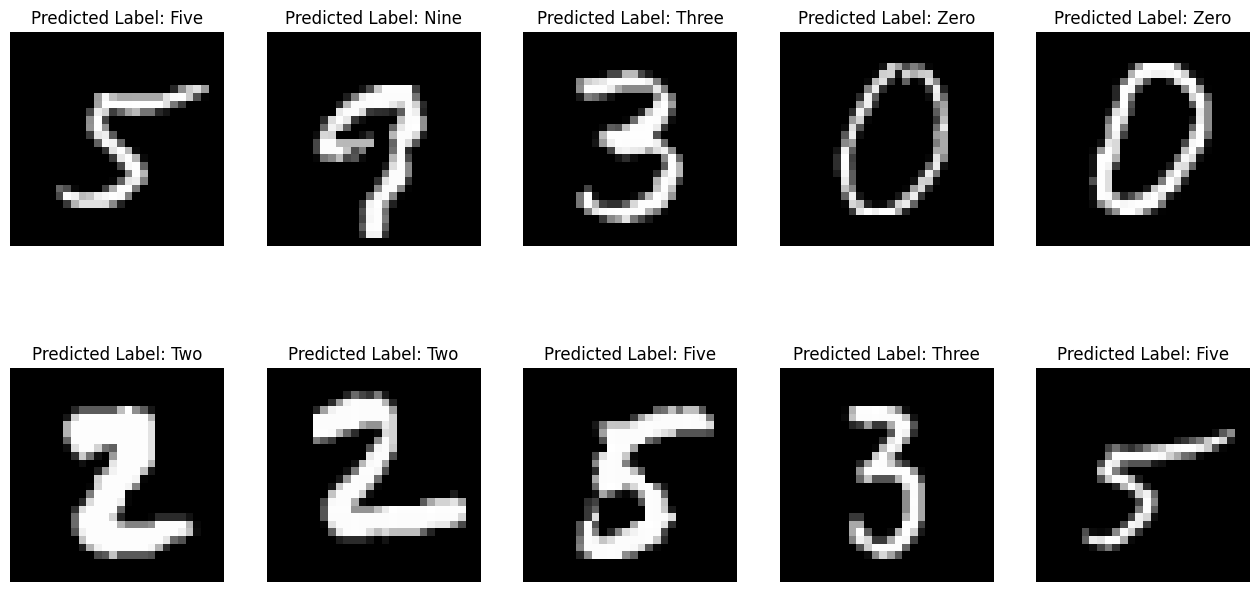

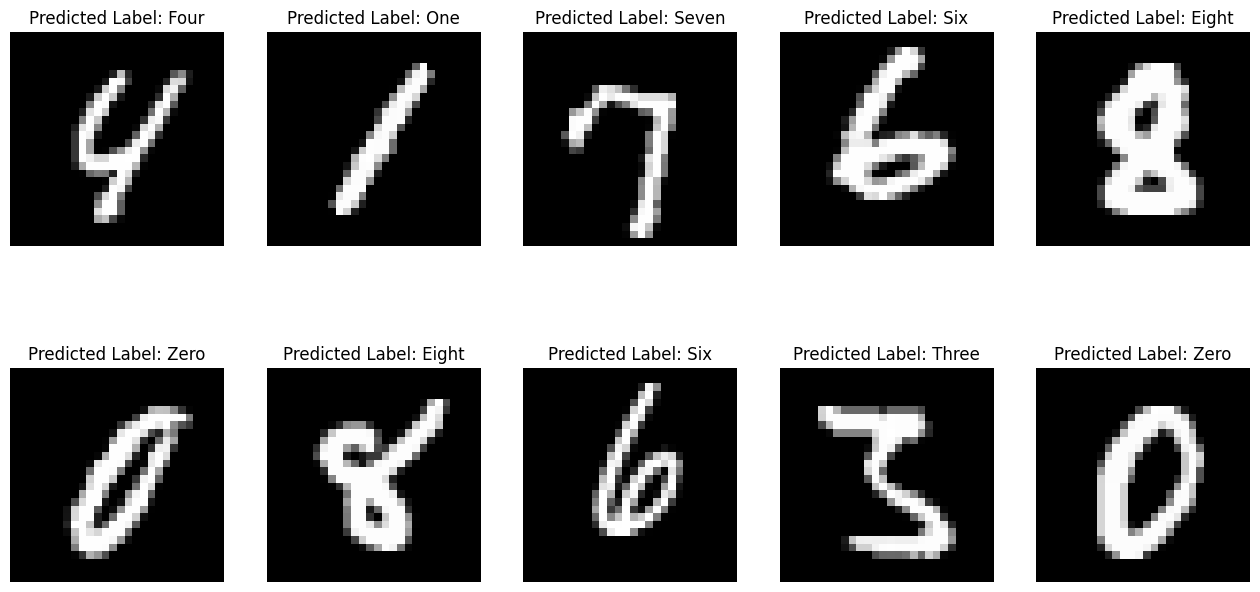

Epoch: 25, Mean loss: 0.0007298821146661446


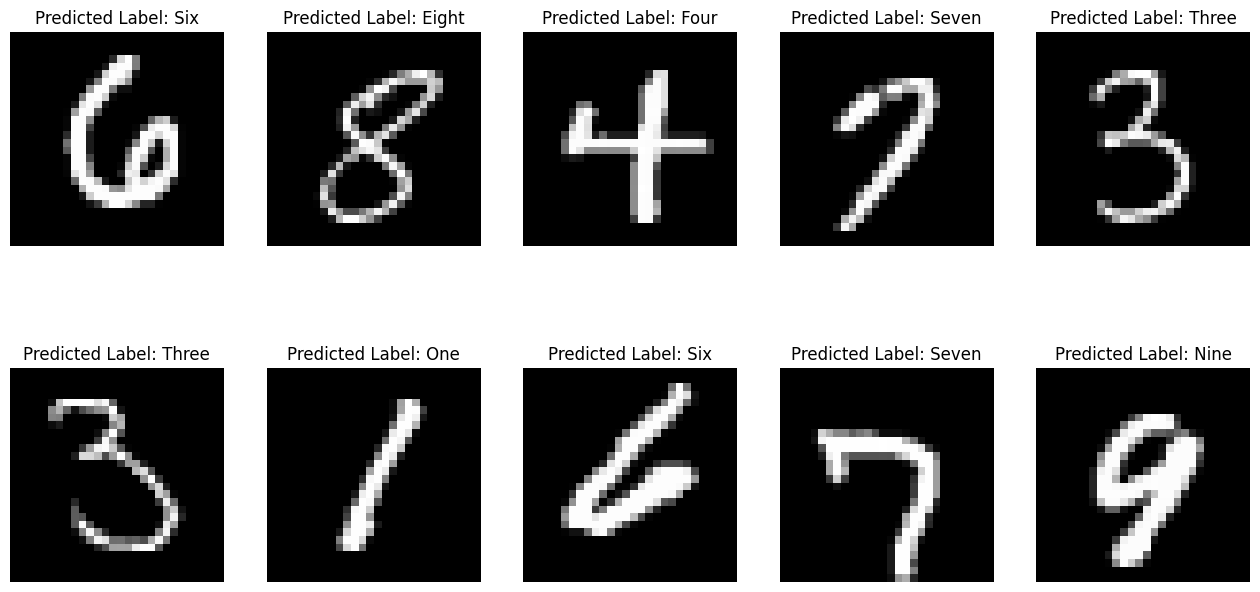

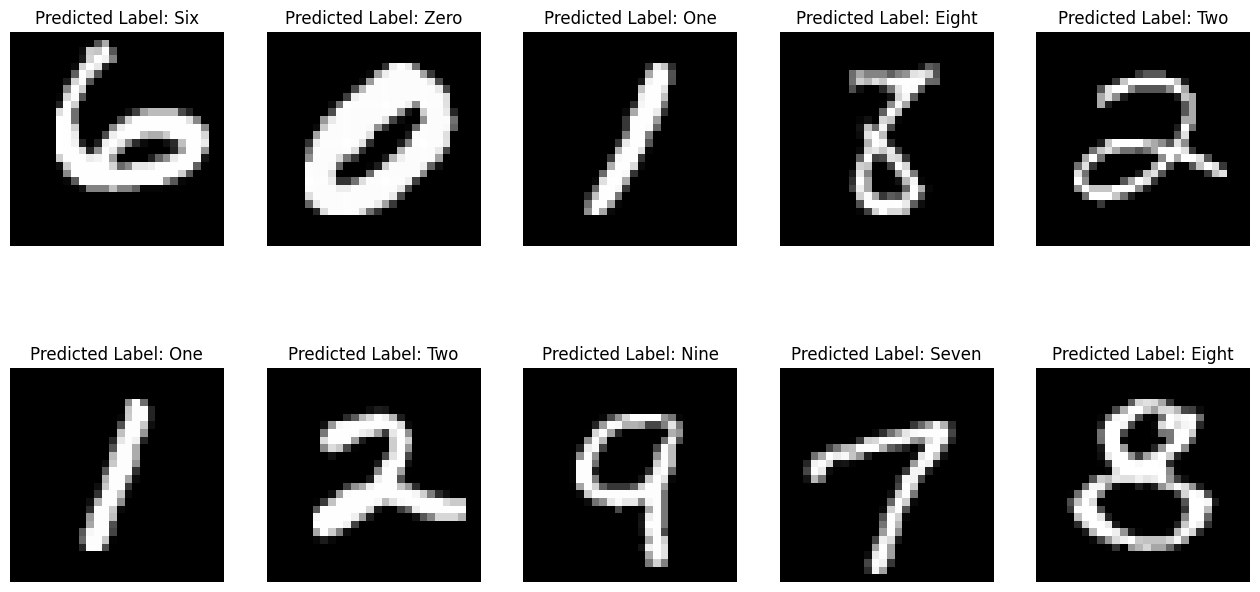

Epoch: 30, Mean loss: 0.0006629702575867132


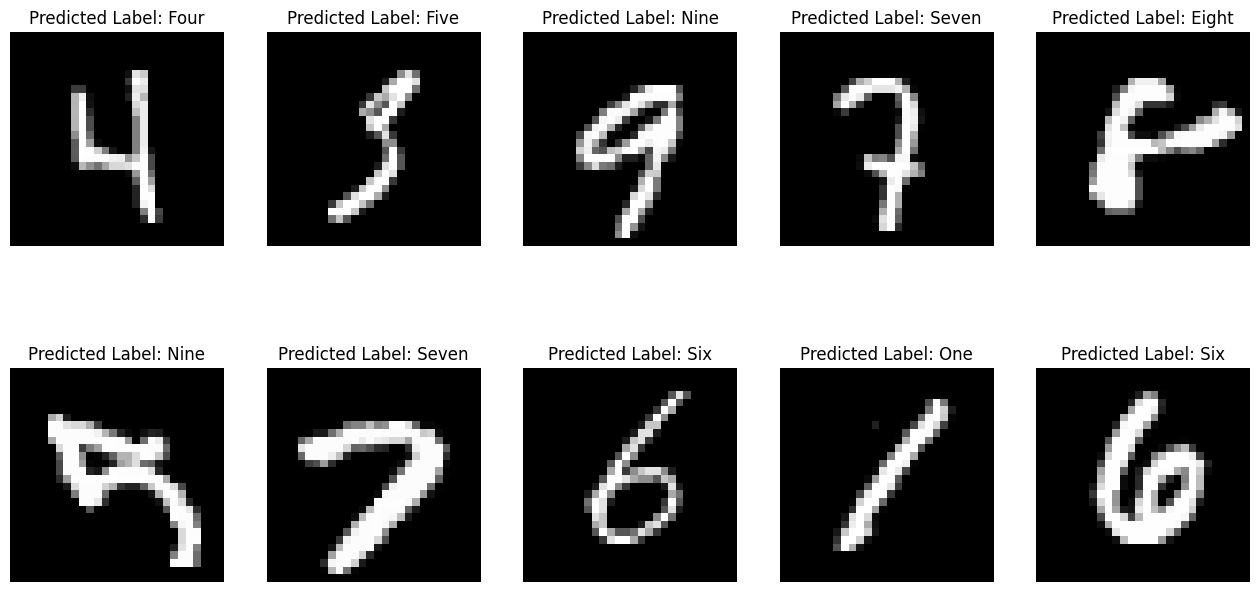

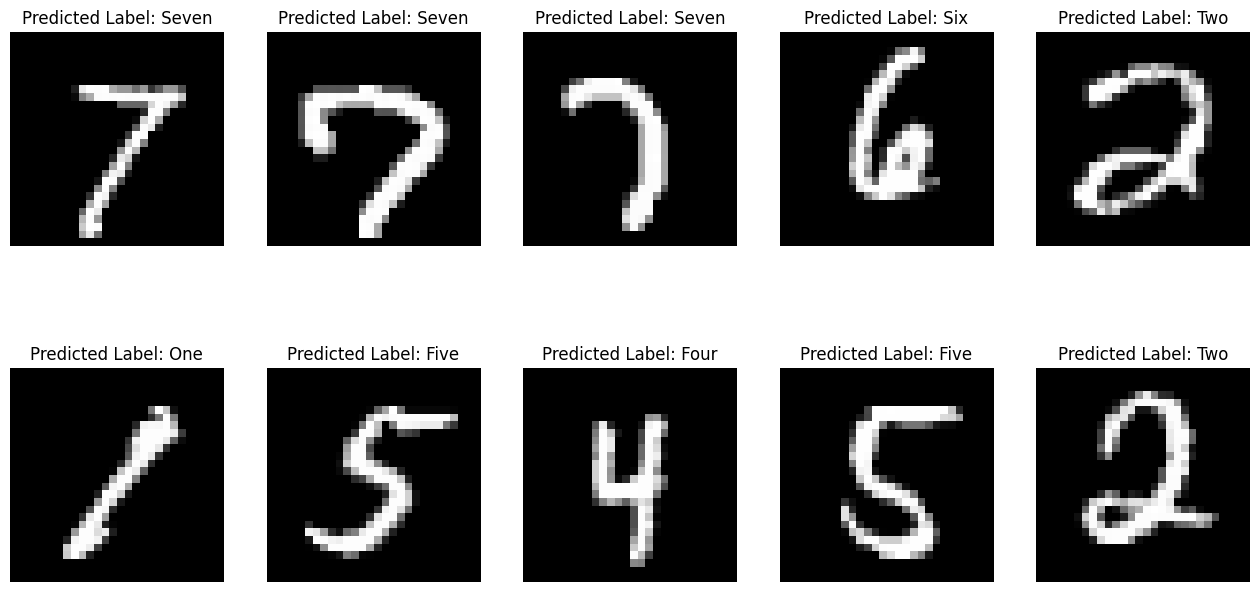

Epoch: 35, Mean loss: 0.00060400179461056


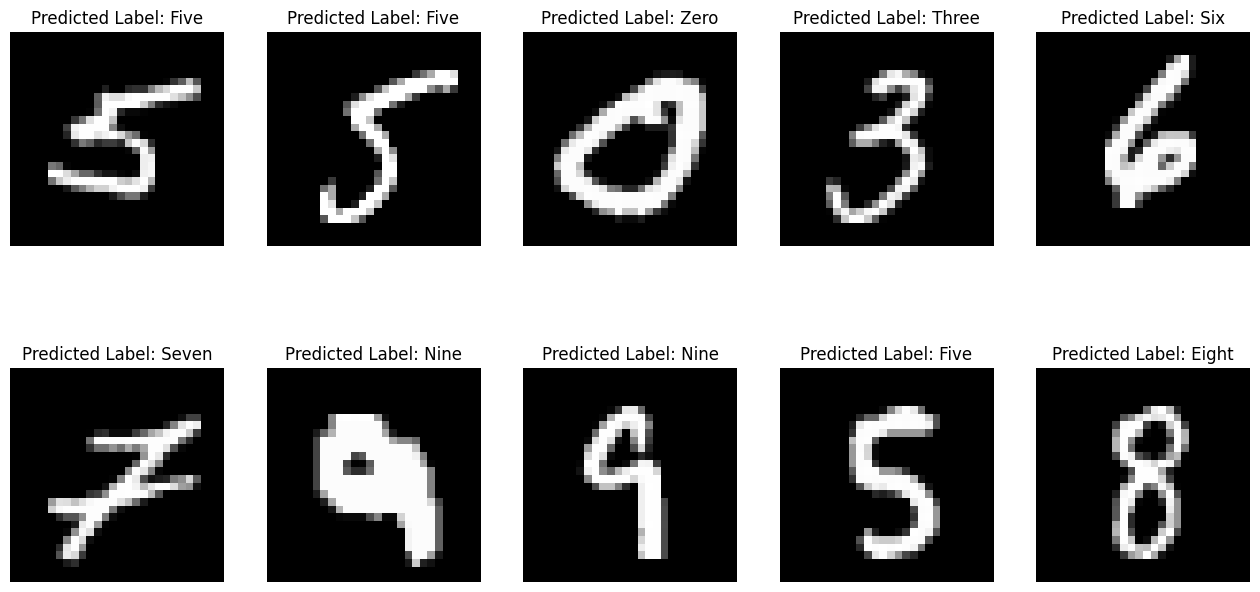

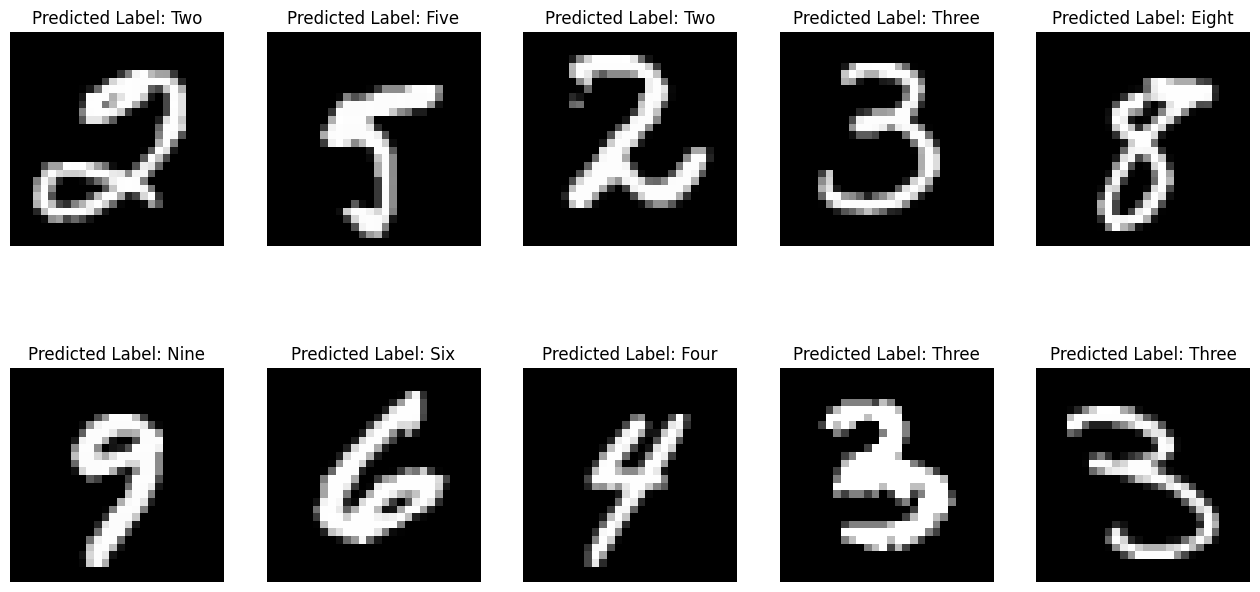

Epoch: 40, Mean loss: 0.0005532040735132578


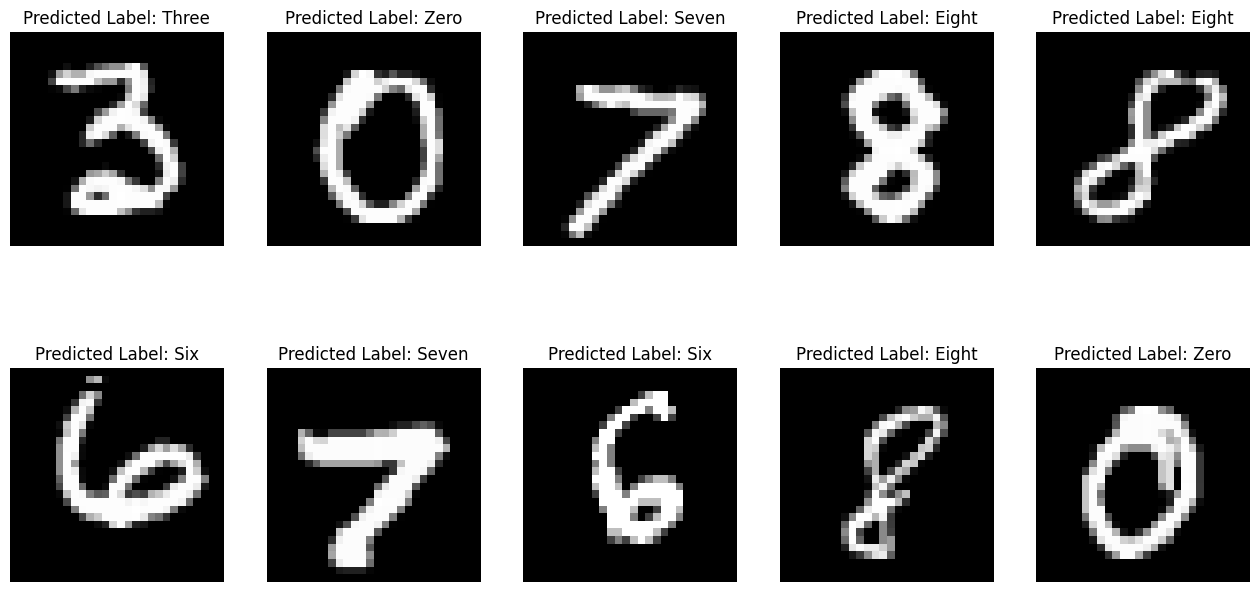

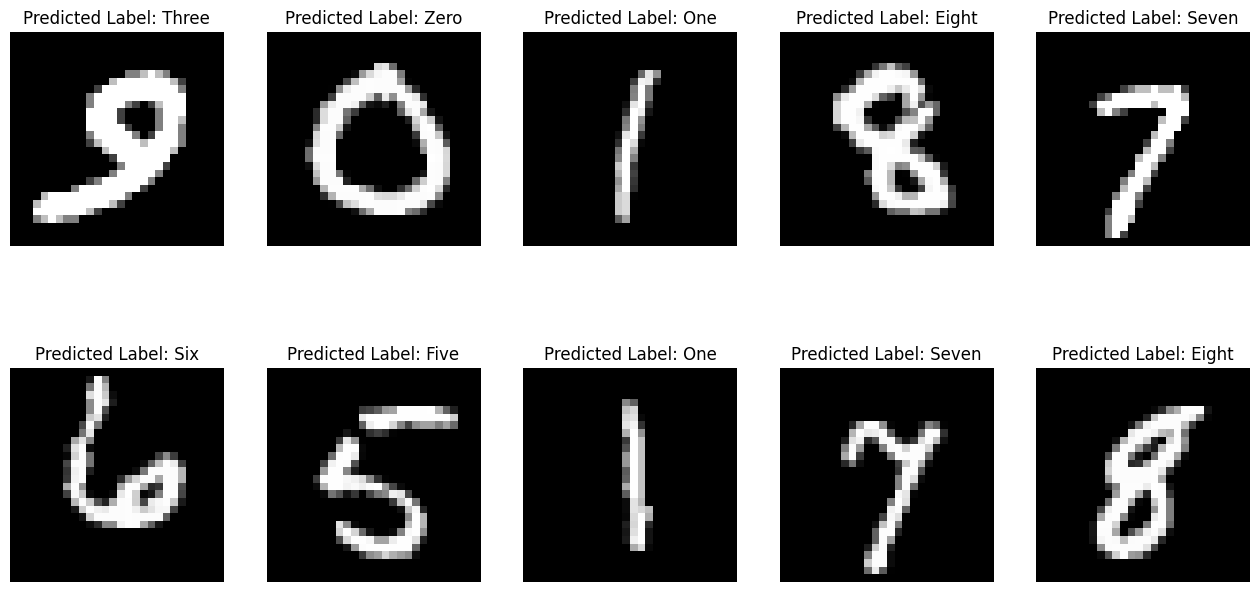

Epoch: 45, Mean loss: 0.0005095468974571182


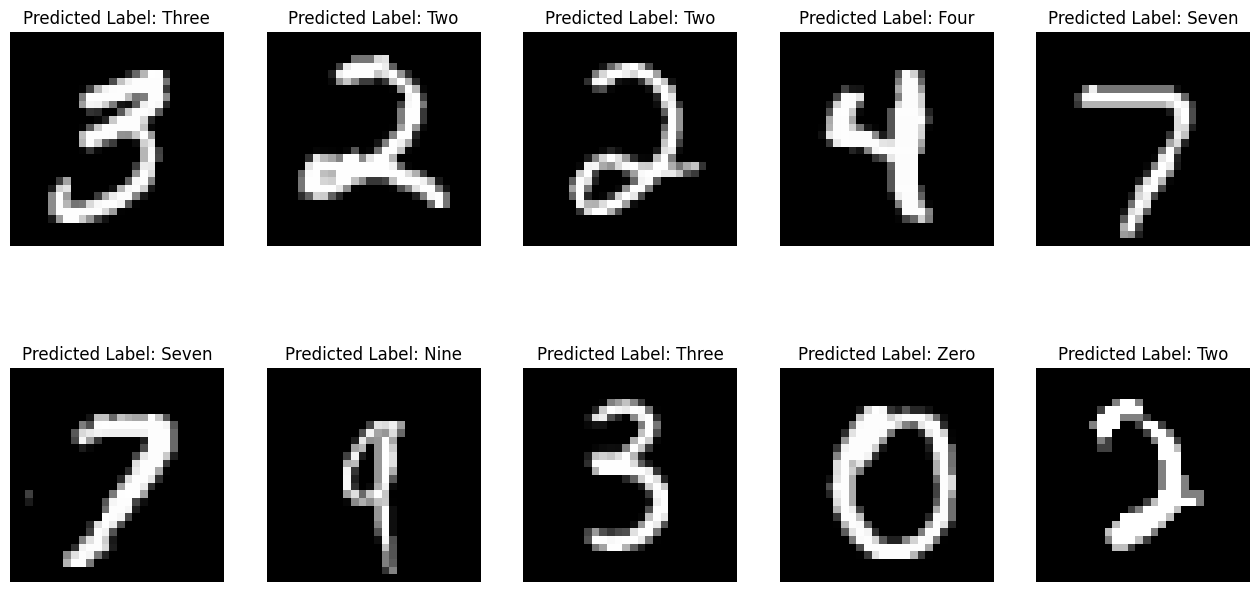

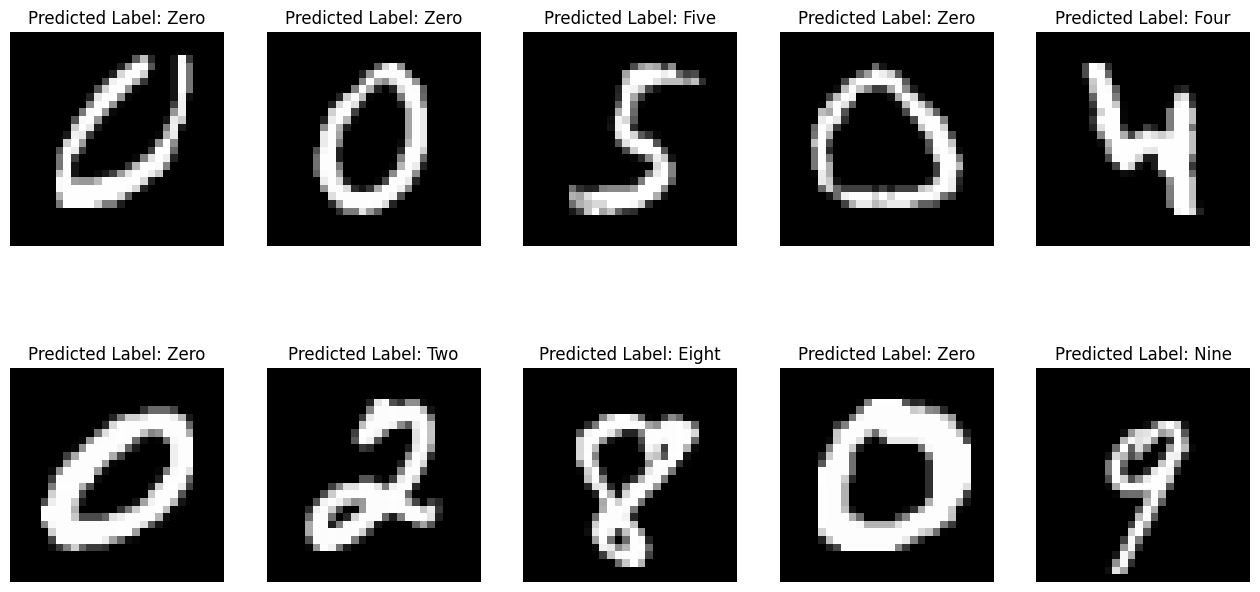

In [20]:
opt = torch.optim.Adam(net.parameters(), lr=0.0001)

train(net, opt, epochs=50,
      train_data=training_data,
      val_data=val_data,
      test_data=test_data,
      batch_size=BATCH_SIZE,
      device=device,
      eval_frq=5)


## Autres choses

1. Changer la fonction d'activation (`tanh`, `sigmoid`, `ReLU` etc) et comparer la convergence.
1. Changer le `learning rate` ($\alpha$) de SGD, et comparer la vitesse de convergence
2. Au lieu de SGD, utiliser Adam et comparer les vitesses de convergence




📊 Classification report :

              precision    recall  f1-score   support

           0     0.9808    0.9898    0.9853       980
           1     0.9938    0.9894    0.9916      1135
           2     0.9710    0.9748    0.9729      1032
           3     0.9704    0.9752    0.9728      1010
           4     0.9755    0.9715    0.9735       982
           5     0.9818    0.9686    0.9752       892
           6     0.9823    0.9823    0.9823       958
           7     0.9766    0.9757    0.9762      1028
           8     0.9674    0.9754    0.9714       974
           9     0.9721    0.9683    0.9702      1009

    accuracy                         0.9773     10000
   macro avg     0.9772    0.9771    0.9771     10000
weighted avg     0.9773    0.9773    0.9773     10000

Test Accuracy = 97.73%


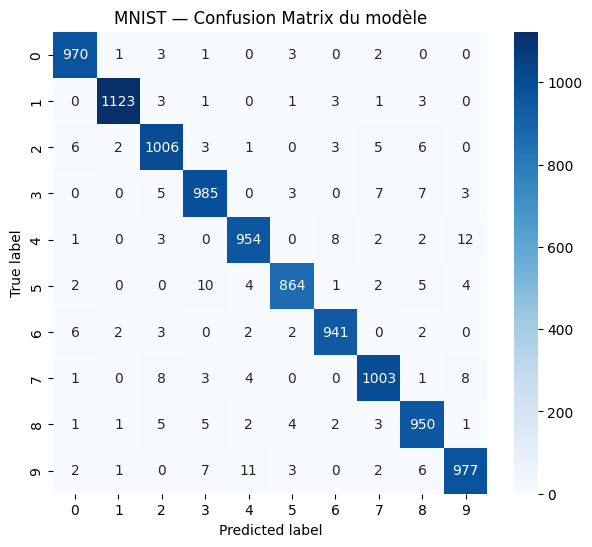

In [21]:
# ============================================================
# Évaluation Finale du modèle
# Accuracy + Precision + Recall + F1 + Confusion Matrix
# ============================================================

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

net.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = net(x)
        preds = torch.argmax(out, dim=1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ------- Résultats détaillés -------
print("\n📊 Classification report :\n")
print(classification_report(y_true, y_pred, digits=4))

print(f"Test Accuracy = {accuracy_score(y_true, y_pred)*100:.2f}%")

# ------- Matrice de confusion -------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("MNIST — Confusion Matrix du modèle")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
